## 2021 Emory REU/RET: PyTorch Segmentation Model

    Elle Buser
    7/25/21

Model:

- Input: Tensor of size [n, 3, 256, 256] where n is the number of DENSE image sets.

      3 corresponds to number of channels: magnitude, mean displacement, and peak displacement DENSE images respectively. 

      256, 256 is number of pixels (image size).

- Output: Tensor of size [n, 3, 256, 256]

      3 corresponds to the number of classes in the segmentation: background, cerebellum, and brain stem.

Function: segment(DENSE_image, save_path, model_info)

- Inputs:

      -DENSE_image: Input images [n, 3, 256, 256]

      -save_folder: Where the output mask is saved (str)

      -model_info: 
          1: to output model's state_dict 
          0: otherwise

- Outputs:

      -Grid of magnitude DENSE image(s) and segmented mask(s)

      -Saves each mask segmentation as a .png file in the save_folder

      -Saves mask segmentations in a .mat file in save_folder

      -Model's state_dict (if model_info = 1)

      -Model Loss

      -Model and Mask Dice Index
      


## Load Libraries and Data

In [1]:
#Import Libraries
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

import sys, os
import numpy as np
from scipy.spatial import distance
import scipy.io as sio
from scipy.io import savemat

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 8})
plt.rcParams.update({'image.interpolation' : None})
plt.rcParams['figure.figsize'] = [8, 5]
plt.rcParams['figure.dpi'] = 200

import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.optim as optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

#Import Test Data
dataTest_n = sio.loadmat('/content/gdrive/My Drive/Chiari/Data/normalizedChiariTestData-v2.mat') #Normalized Magnitude Images and Mask
dataTest_p = sio.loadmat('/content/gdrive/My Drive/Chiari/Data/chiariTestData-v2.mat') #Phase Images

#Print Data Set Names in .mat file
print(sorted(dataTest_n.keys()))
print(sorted(dataTest_p.keys()))

Mounted at /content/gdrive
cuda:0
['__globals__', '__header__', '__version__', 'masksTest', 'normalTest', 'originalTest']
['__globals__', '__header__', '__version__', 'imagesTest', 'masksTest', 'meanDisplacementTest', 'peakDisplacementTest']


In [2]:
#Creat Input from Test Set
imagesN = torch.tensor(dataTest_n['normalTest'],dtype=torch.float32, device=device).permute((2,0,1)).unsqueeze(1)
target_masks = torch.tensor(dataTest_n['masksTest'],dtype=torch.long, device=device).permute((2,0,1))
images_mean = torch.tensor(dataTest_p['meanDisplacementTest'],dtype=torch.float32, device=device).permute((2,0,1)).unsqueeze(1)
images_peak = torch.tensor(dataTest_p['peakDisplacementTest'],dtype=torch.float32, device=device).permute((2,0,1)).unsqueeze(1)
images = torch.cat((imagesN, images_mean, images_peak),1) #Combine Images Into Single Tensor
print(images.shape)

torch.Size([13, 3, 256, 256])


## Setup U-Net and Loss Function
UNET based on the blog post https://amaarora.github.io/2020/09/13/unet.html.

In [3]:
class Block(nn.Module):
    def __init__(self, in_ch, out_ch, device='cpu'):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3,padding=1, device=device)
        self.relu  = nn.ReLU()
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3,padding=1, device=device)
        #conv layers: increase depth (& number of channels) of the input image

    def forward(self, x):
        return self.conv2(self.relu(self.conv1(x)))


class Encoder(nn.Module):
    def __init__(self, chs=(3,64,128,256,512,1024), device='cpu'):
        super().__init__()
        self.enc_blocks = nn.ModuleList([Block(chs[i], chs[i+1], device=device) for i in range(len(chs)-1)])
        self.pool       = nn.MaxPool2d(2) #MaxPool: halves size of image
    
    def forward(self, x):
        ftrs = []
        for block in self.enc_blocks:
            x = block(x)
            ftrs.append(x)
            x = self.pool(x)
        return ftrs


class Decoder(nn.Module):
    def __init__(self, chs=(1024, 512, 256, 128, 64), device='cpu'):
        super().__init__()
        self.chs         = chs
        self.upconvs    = nn.ModuleList([nn.ConvTranspose2d(chs[i], chs[i+1], 2, 2, device=device) for i in range(len(chs)-1)])
        self.dec_blocks = nn.ModuleList([Block(chs[i], chs[i+1], device=device) for i in range(len(chs)-1)]) 
        
    def forward(self, x, encoder_features):
        for i in range(len(self.chs)-1):
            x        = self.upconvs[i](x)
            enc_ftrs = self.crop(encoder_features[i], x)
            x        = torch.cat([x, enc_ftrs], dim=1)
            x        = self.dec_blocks[i](x)
        return x
    
    def crop(self, enc_ftrs, x):
        _, _, H, W = x.shape
        enc_ftrs   = torchvision.transforms.CenterCrop([H, W])(enc_ftrs)
        return enc_ftrs


class UNet(nn.Module):
    def __init__(self, enc_chs=(3,64,128,256,512,1024), dec_chs=(1024, 512, 256, 128, 64), num_class=3, retain_dim=False, out_sz=(572,572), device='cpu'):
        super().__init__() 
        self.encoder     = Encoder(enc_chs, device=device)
        self.decoder     = Decoder(dec_chs, device=device)
        self.head        = nn.Conv2d(dec_chs[-1], num_class, 1, device=device) # Changed num_class=1 -> 3 above to make 3 channels
        self.retain_dim  = retain_dim

    def forward(self, x):
        enc_ftrs = self.encoder(x)
        out      = self.decoder(enc_ftrs[::-1][0], enc_ftrs[::-1][1:])
        out      = self.head(out)
        if self.retain_dim:
            out = F.interpolate(out, out_sz)
        return out

#Define Loss Function
loss = nn.CrossEntropyLoss()

## Define Segmentation Function

In [31]:
#Dice Index Function
def dice(k, label, prediction):
  masks_sum = torch.sum(label == k) + torch.sum(prediction == k)
  inter = torch.sum(torch.mul(label == k, prediction == k))
  diceIndex = (2 * (inter + 0.001)) / (masks_sum + 0.001) #Add 0.001 in case inter = 0
  return diceIndex

#Segmentation Function
def segment(DENSE_image, save_folder, model_info):
  
  save_path = '/content/gdrive/My Drive/Chiari/Colab/results/' + save_folder +'/' #Path to Save Results

  if not(os.path.exists(save_path)):
    os.mkdir(save_path) #Make Folder for Image Batch
  
  #Load Model
  model_path = '/content/gdrive/My Drive/Chiari/Colab/results/UNet_Model'
  model = torch.load(model_path)
  model.to(device)
  model.eval()

  #Print Model's state_dict if requested
  if model_info == 1:
    print("Model's Information:")
    for param_tensor in model.state_dict():
        print(param_tensor, "\t", model.state_dict()[param_tensor].size())
  if model_info != 0 and model_info != 1:
    print('Invalid model_info Input. Input 1 if you want model information or 0 if not.')

  #In Case Single Image and not 4D Tensor:
  if len(DENSE_image.shape) == 3: 
    DENSE_image = images.unsqueeze(0)

  #Run Input Images Through Model
  predicted_masks = model(DENSE_image)

  #Normalize Mask Segmentations
  masks_norm = torch.argmax(predicted_masks, dim=1)

  #Calculate and Print Model Loss and Dice Index
  model_loss = loss(predicted_masks, target_masks)
  print('Model Loss = ', model_loss.item())
  print('-------------------------------------')
  dice_background = dice(0,target_masks, masks_norm).cpu().numpy()
  print('Total Background Dice = ', dice_background)
  dice_cerebellum = dice(1,target_masks, masks_norm).cpu().numpy()
  print('Total Cerebellum Dice = ', dice_cerebellum)
  dice_brainstem =  dice(2,target_masks, masks_norm).cpu().numpy()
  print('Total Brain Stem Dice = ', dice_brainstem)
  print('-------------------------------------')
  print('Mask|Background|Cerebellum|Brain Stem')


  #Save Mask Segmentations
  for mask in range(len(predicted_masks)):
    #Create Mask Image
    plt.figure(1)
    masks = (masks_norm - torch.min(masks_norm)) / torch.max(masks_norm)
    plt.imshow(masks[mask].squeeze(0).cpu().numpy(),cmap='gray')
    plt.axis("off") 
    plt.savefig(save_path + '/_'+ 'segmentation_mask' + str(mask+1))
    plt.figure(1).clf()
    #Print Dice for Each Mask
    print('%3d' % (mask), '%8.4f' % (dice(0, target_masks[mask], masks_norm[mask]).cpu().numpy()), \
          '%10.4f' % (dice(1, target_masks[mask], masks_norm[mask]).cpu().numpy()), \
          '%10.4f' % (dice(2, target_masks[mask], masks_norm[mask]).cpu().numpy()))

  #Output .mat file with masks
  mdic = {"testMask": masks_norm.cpu().numpy()}
  savemat(save_path + "testData_masks.mat", mdic)

  #Plot Magnitude Image and Mask Side-By-Side
  plt.figure(2)
  plt.imshow(torchvision.utils.make_grid((imagesN/torch.max(imagesN)).cpu(),8,padding=5,pad_value=1.0).permute((1,2,0)),cmap='gray')
  plt.axis("off")
  plt.title('Normalized MRI Images')
  plt.margins(0, 0)
  plt.figure(2).savefig(save_path + 'Norm_Images')
  plt.show(2)

  plt.figure(3)
  imout = masks_norm-torch.min(masks_norm)
  imout = imout / torch.max(imout)
  plt.imshow(torchvision.utils.make_grid(imout.unsqueeze(1).cpu(),8,padding=5,pad_value=1.0).permute((1,2,0)),cmap='gray')
  plt.axis("off")
  plt.title('Segmentation Masks')
  plt.margins(0, 0)
  plt.figure(3).savefig(save_path + 'Segmentation_Images')
  plt.show(3)
  

## Run Function

Model Loss =  0.032329343259334564
-------------------------------------
Total Background Dice =  0.9936234
Total Cerebellum Dice =  0.85994846
Total Brain Stem Dice =  0.8541792
-------------------------------------
Mask|Background|Cerebellum|Brain Stem
  0   0.9929     0.8272     0.8400
  1   0.9953     0.8955     0.8634
  2   0.9941     0.8438     0.8769
  3   0.9912     0.8053     0.7115
  4   0.9941     0.8763     0.9036
  5   0.9878     0.7404     0.6745
  6   0.9974     0.9356     0.9362
  7   0.9963     0.8966     0.9569
  8   0.9950     0.9009     0.8663
  9   0.9934     0.8453     0.8686
 10   0.9946     0.8763     0.9107
 11   0.9904     0.8807     0.7695
 12   0.9948     0.8261     0.9328


<Figure size 432x288 with 0 Axes>

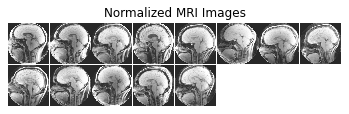

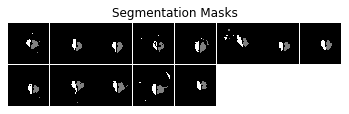

In [32]:
segment(images, 'testDataSegmentations', 0)